In [1]:
#Support vector machines (SVMs) are a set of supervised learning methods used 
# for classification, regression and outliers detection.

In [9]:
from sklearn import svm
x = [[0,0],[1,1]]
y = [0,1]
clf = svm.SVC()
print(clf.fit(x,y))
print(clf.predict([[2,2]]))
print(clf.support_vectors_)
print(clf.support_)
print(clf.n_support_)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
[1]
[[ 0.  0.]
 [ 1.  1.]]
[0 1]
[1 1]


In [12]:
#Multi-class classification
x = [[0], [1], [2], [3]]
y = [0, 1, 2, 3]
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(x, y)
dec = clf.decision_function([[1]])
print(dec.shape[1])  #4*3/2=6

clf.decision_function_shape = "ovr"
dec = clf.decision_function([[1]])
print(dec.shape[1])

lin_clf = svm.LinearSVC()
lin_clf.fit(x,y)
dec = lin_clf.decision_function([[1]])
print(dec.shape[1])


6
4
4


In [13]:
#Regression
from sklearn import svm
x = [[0,0],[2,2]]
y = [0.5,2.5]
clf = svm.SVR()
clf.fit(x,y)
clf.predict([[1,1]])

array([ 1.5])

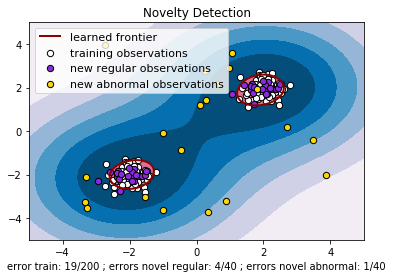

In [14]:
#One-class SVM with non-linear kernel (RBF)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
# Generate train data
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s,
                 edgecolors='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s,
                edgecolors='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; "
    "errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers))
plt.show()

Automatically created module for IPython interactive environment


________________________________________________________________________________
Modeling distribution of species 'bradypus variegatus'
 - fit OneClassSVM ... done.
 - plot coastlines from coverage
 - predict species distribution


/home/liu/py3venv/lib/python3.5/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"



 Area under the ROC curve : 0.868443
________________________________________________________________________________
Modeling distribution of species 'microryzomys minutus'
 - fit OneClassSVM ... done.
 - plot coastlines from coverage
 - predict species distribution



 Area under the ROC curve : 0.993919

time elapsed: 57.56s


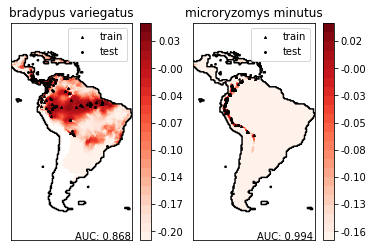

In [15]:
#Species distribution modeling
from __future__ import print_function

from time import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets.base import Bunch
from sklearn.datasets import fetch_species_distributions
from sklearn.datasets.species_distributions import construct_grids
from sklearn import svm, metrics

# if basemap is available, we'll use it.
# otherwise, we'll improvise later...
try:
    from mpl_toolkits.basemap import Basemap
    basemap = True
except ImportError:
    basemap = False

print(__doc__)


def create_species_bunch(species_name, train, test, coverages, xgrid, ygrid):
    """Create a bunch with information about a particular organism

    This will use the test/train record arrays to extract the
    data specific to the given species name.
    """
    bunch = Bunch(name=' '.join(species_name.split("_")[:2]))
    species_name = species_name.encode('ascii')
    points = dict(test=test, train=train)

    for label, pts in points.items():
        # choose points associated with the desired species
        pts = pts[pts['species'] == species_name]
        bunch['pts_%s' % label] = pts

        # determine coverage values for each of the training & testing points
        ix = np.searchsorted(xgrid, pts['dd long'])
        iy = np.searchsorted(ygrid, pts['dd lat'])
        bunch['cov_%s' % label] = coverages[:, -iy, ix].T

    return bunch


def plot_species_distribution(species=("bradypus_variegatus_0",
                                       "microryzomys_minutus_0")):
    """
    Plot the species distribution.
    """
    if len(species) > 2:
        print("Note: when more than two species are provided,"
              " only the first two will be used")

    t0 = time()

    # Load the compressed data
    data = fetch_species_distributions()

    # Set up the data grid
    xgrid, ygrid = construct_grids(data)

    # The grid in x,y coordinates
    X, Y = np.meshgrid(xgrid, ygrid[::-1])

    # create a bunch for each species
    BV_bunch = create_species_bunch(species[0],
                                    data.train, data.test,
                                    data.coverages, xgrid, ygrid)
    MM_bunch = create_species_bunch(species[1],
                                    data.train, data.test,
                                    data.coverages, xgrid, ygrid)

    # background points (grid coordinates) for evaluation
    np.random.seed(13)
    background_points = np.c_[np.random.randint(low=0, high=data.Ny,
                                                size=10000),
                              np.random.randint(low=0, high=data.Nx,
                                                size=10000)].T

    # We'll make use of the fact that coverages[6] has measurements at all
    # land points.  This will help us decide between land and water.
    land_reference = data.coverages[6]

    # Fit, predict, and plot for each species.
    for i, species in enumerate([BV_bunch, MM_bunch]):
        print("_" * 80)
        print("Modeling distribution of species '%s'" % species.name)

        # Standardize features
        mean = species.cov_train.mean(axis=0)
        std = species.cov_train.std(axis=0)
        train_cover_std = (species.cov_train - mean) / std

        # Fit OneClassSVM
        print(" - fit OneClassSVM ... ", end='')
        clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.5)
        clf.fit(train_cover_std)
        print("done.")

        # Plot map of South America
        plt.subplot(1, 2, i + 1)
        if basemap:
            print(" - plot coastlines using basemap")
            m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                        urcrnrlat=Y.max(), llcrnrlon=X.min(),
                        urcrnrlon=X.max(), resolution='c')
            m.drawcoastlines()
            m.drawcountries()
        else:
            print(" - plot coastlines from coverage")
            plt.contour(X, Y, land_reference,
                        levels=[-9999], colors="k",
                        linestyles="solid")
            plt.xticks([])
            plt.yticks([])

        print(" - predict species distribution")

        # Predict species distribution using the training data
        Z = np.ones((data.Ny, data.Nx), dtype=np.float64)

        # We'll predict only for the land points.
        idx = np.where(land_reference > -9999)
        coverages_land = data.coverages[:, idx[0], idx[1]].T

        pred = clf.decision_function((coverages_land - mean) / std)[:, 0]
        Z *= pred.min()
        Z[idx[0], idx[1]] = pred

        levels = np.linspace(Z.min(), Z.max(), 25)
        Z[land_reference == -9999] = -9999

        # plot contours of the prediction
        plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)
        plt.colorbar(format='%.2f')

        # scatter training/testing points
        plt.scatter(species.pts_train['dd long'], species.pts_train['dd lat'],
                    s=2 ** 2, c='black',
                    marker='^', label='train')
        plt.scatter(species.pts_test['dd long'], species.pts_test['dd lat'],
                    s=2 ** 2, c='black',
                    marker='x', label='test')
        plt.legend()
        plt.title(species.name)
        plt.axis('equal')

        # Compute AUC with regards to background points
        pred_background = Z[background_points[0], background_points[1]]
        pred_test = clf.decision_function((species.cov_test - mean)
                                          / std)[:, 0]
        scores = np.r_[pred_test, pred_background]
        y = np.r_[np.ones(pred_test.shape), np.zeros(pred_background.shape)]
        fpr, tpr, thresholds = metrics.roc_curve(y, scores)
        roc_auc = metrics.auc(fpr, tpr)
        plt.text(-35, -70, "AUC: %.3f" % roc_auc, ha="right")
        print("\n Area under the ROC curve : %f" % roc_auc)

    print("\ntime elapsed: %.2fs" % (time() - t0))


plot_species_distribution()
plt.show()

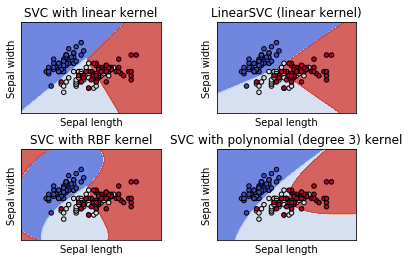

In [1]:
#Plot different SVM classifiers in the iris dataset,
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets


def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


# import some data to play with
iris = datasets.load_iris()
# Take the first two features. We could avoid this by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C),
          svm.LinearSVC(C=C),
          svm.SVC(kernel='rbf', gamma=0.7, C=C),
          svm.SVC(kernel='poly', degree=3, C=C))
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel')

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

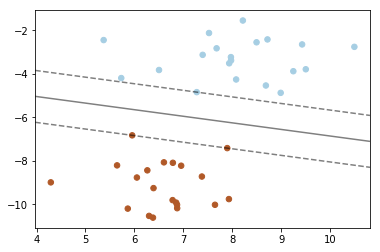

In [2]:
#SVM: Maximum margin separating hyperplane
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs


# we create 40 separable points
X, y = make_blobs(n_samples=40, centers=2, random_state=6)

# fit the model, don't regularize for illustration purposes
clf = svm.SVC(kernel='linear', C=1000)
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none')
plt.show()

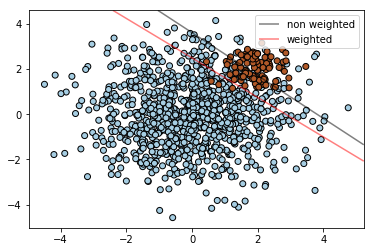

In [3]:
#SVM: Separating hyperplane for unbalanced classes
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

# we create clusters with 1000 and 100 points
rng = np.random.RandomState(0)
n_samples_1 = 1000
n_samples_2 = 100
X = np.r_[1.5 * rng.randn(n_samples_1, 2),
          0.5 * rng.randn(n_samples_2, 2) + [2, 2]]
y = [0] * (n_samples_1) + [1] * (n_samples_2)

# fit the model and get the separating hyperplane
clf = svm.SVC(kernel='linear', C=1.0)
clf.fit(X, y)

# fit the model and get the separating hyperplane using weighted classes
wclf = svm.SVC(kernel='linear', class_weight={1: 10})
wclf.fit(X, y)

# plot separating hyperplanes and samples
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')
plt.legend()

# plot the decision functions for both classifiers
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

# get the separating hyperplane
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
a = ax.contour(XX, YY, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])

# get the separating hyperplane for weighted classes
Z = wclf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins for weighted classes
b = ax.contour(XX, YY, Z, colors='r', levels=[0], alpha=0.5, linestyles=['-'])

plt.legend([a.collections[0], b.collections[0]], ["non weighted", "weighted"],
           loc="upper right")
plt.show()

/home/liu/py3venv/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 0  7  8 15 16 23 24 31 32 39 40 47 48 56 63] are constant.
  UserWarning)
/home/liu/py3venv/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/liu/py3venv/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 0  8 15 16 23 31 32 39 40 48 56] are constant.
  UserWarning)
/home/liu/py3venv/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/liu/py3venv/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 0  8 15 16 23 31 32 39 40 48 56] are constant.
  UserWarning)
/home/liu/py3venv/lib/python3.5/site-packages/sklearn/feature_selection/univari

/home/liu/py3venv/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 0  7  8 15 16 23 24 31 32 39 40 47 48 56 63] are constant.
  UserWarning)
/home/liu/py3venv/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/liu/py3venv/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 0  8 15 16 23 31 32 39 40 48 56] are constant.
  UserWarning)
/home/liu/py3venv/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/liu/py3venv/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 0  8 15 16 23 31 32 39 40 48 56] are constant.
  UserWarning)
/home/liu/py3venv/lib/python3.5/site-packages/sklearn/feature_selection/univari

/home/liu/py3venv/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 0  8 15 16 23 31 32 39 40 48 56] are constant.
  UserWarning)
/home/liu/py3venv/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/liu/py3venv/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 0  7  8 15 16 23 24 31 32 39 40 47 48 56 63] are constant.
  UserWarning)
/home/liu/py3venv/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/liu/py3venv/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 0  8 15 16 23 31 32 39 40 48 56] are constant.
  UserWarning)
/home/liu/py3venv/lib/python3.5/site-packages/sklearn/feature_selection/univari

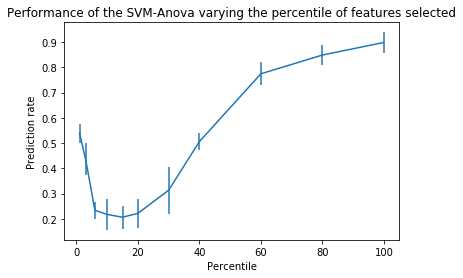

In [4]:
#SVM-Anova: SVM with univariate feature selection,
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets, feature_selection
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

# #############################################################################
# Import some data to play with
digits = datasets.load_digits()
y = digits.target
# Throw away data, to be in the curse of dimension settings
y = y[:200]
X = digits.data[:200]
n_samples = len(y)
X = X.reshape((n_samples, -1))
# add 200 non-informative features
X = np.hstack((X, 2 * np.random.random((n_samples, 200))))

# #############################################################################
# Create a feature-selection transform and an instance of SVM that we
# combine together to have an full-blown estimator

transform = feature_selection.SelectPercentile(feature_selection.f_classif)

clf = Pipeline([('anova', transform), ('svc', svm.SVC(C=1.0))])

# #############################################################################
# Plot the cross-validation score as a function of percentile of features
score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    # Compute cross-validation score using 1 CPU
    this_scores = cross_val_score(clf, X, y, n_jobs=1)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

plt.errorbar(percentiles, score_means, np.array(score_stds))

plt.title(
    'Performance of the SVM-Anova varying the percentile of features selected')
plt.xlabel('Percentile')
plt.ylabel('Prediction rate')

plt.axis('tight')
plt.show()

/home/liu/py3venv/lib/python3.5/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'linetypes'
  s)


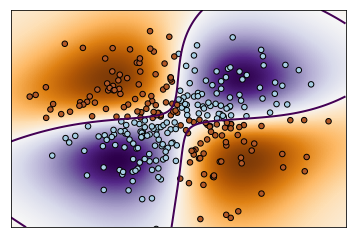

In [6]:
#Non-linear SVM
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

xx, yy = np.meshgrid(np.linspace(-3, 3, 500),
                     np.linspace(-3, 3, 500))
np.random.seed(0)
X = np.random.randn(300, 2)
Y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

# fit the model
clf = svm.NuSVC()
clf.fit(X, Y)

# plot the decision function for each datapoint on the grid
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()), aspect='auto',
           origin='lower', cmap=plt.cm.PuOr_r)
contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2,
                       linetypes='--')
plt.scatter(X[:, 0], X[:, 1], s=30, c=Y, cmap=plt.cm.Paired,
            edgecolors='k')
plt.xticks(())
plt.yticks(())
plt.axis([-3, 3, -3, 3])
plt.show()

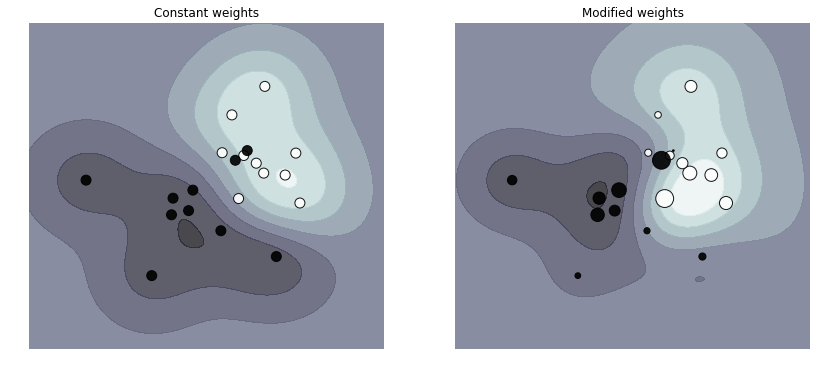

In [7]:
#SVM: Weighted samples,
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm


def plot_decision_function(classifier, sample_weight, axis, title):
    # plot the decision function
    xx, yy = np.meshgrid(np.linspace(-4, 5, 500), np.linspace(-4, 5, 500))

    Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # plot the line, the points, and the nearest vectors to the plane
    axis.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.bone)
    axis.scatter(X[:, 0], X[:, 1], c=y, s=100 * sample_weight, alpha=0.9,
                 cmap=plt.cm.bone, edgecolors='black')

    axis.axis('off')
    axis.set_title(title)


# we create 20 points
np.random.seed(0)
X = np.r_[np.random.randn(10, 2) + [1, 1], np.random.randn(10, 2)]
y = [1] * 10 + [-1] * 10
sample_weight_last_ten = abs(np.random.randn(len(X)))
sample_weight_constant = np.ones(len(X))
# and bigger weights to some outliers
sample_weight_last_ten[15:] *= 5
sample_weight_last_ten[9] *= 15

# for reference, first fit without class weights

# fit the model
clf_weights = svm.SVC()
clf_weights.fit(X, y, sample_weight=sample_weight_last_ten)

clf_no_weights = svm.SVC()
clf_no_weights.fit(X, y)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_decision_function(clf_no_weights, sample_weight_constant, axes[0],
                       "Constant weights")
plot_decision_function(clf_weights, sample_weight_last_ten, axes[1],
                       "Modified weights")

plt.show()